In [1]:
# !pip3 install lightgbm

In [2]:
# !pip3 install sktime

In [23]:
# !pip3 install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.5 MB/s eta 0:00:00


# Datetime Features: Tree-based models
14 April 2024

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import re
from tqdm import tqdm

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
import shap

In [4]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

# Output a pandas df intead of numpy
set_config(transform_output="pandas")

In [5]:
# Functions
def c_mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean(np.abs((y - y_hat) / y))
    return np.round(mape, 4)

## 1) Input data

In [6]:
data = pd.read_csv(
    "victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

print(f"{len(data): ,.0f}")
data.head()

 115,368


,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"


## 2) EDA

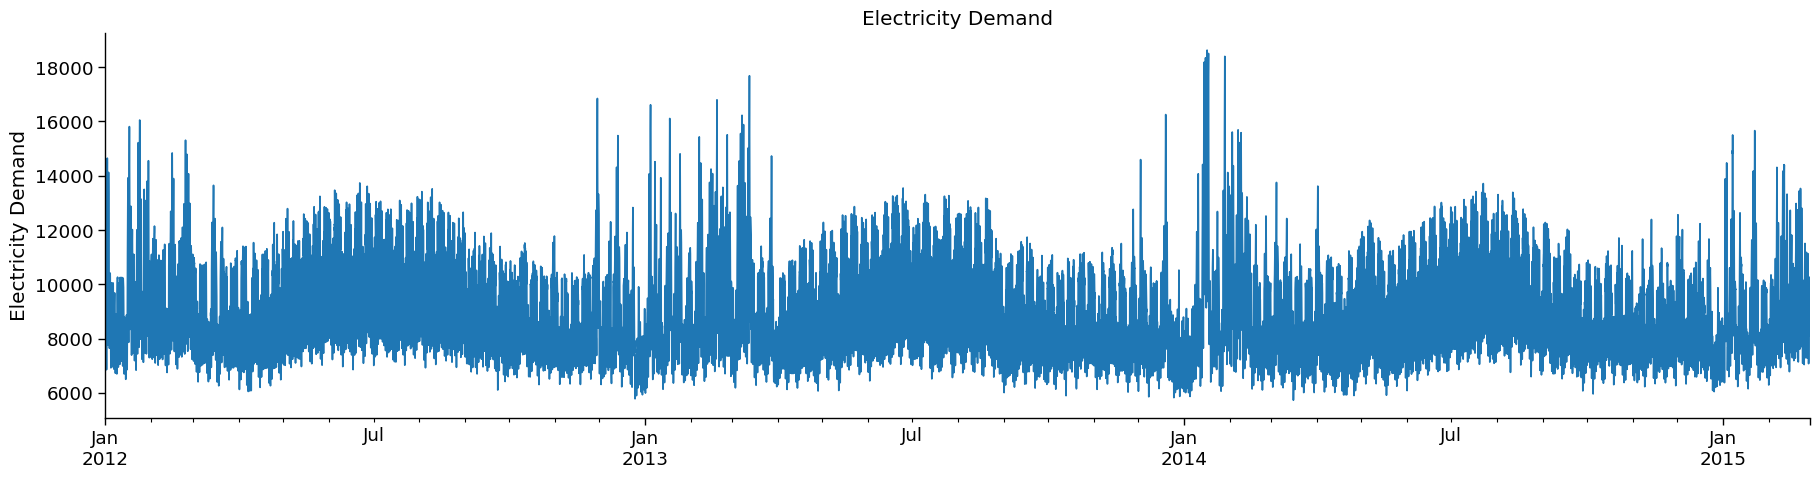

In [7]:
data.loc["2012":].plot(legend=None)

plt.title("Electricity Demand")
plt.xlabel("")
plt.ylabel("Electricity Demand")
plt.show()

### 2.2) Datetime features: sktime

In [8]:
# Specify which datetime features to create
datetime_features = [
    "year",
    "month_of_year",
    "week_of_year",
    "day_of_year",
    "day_of_week",
    "hour_of_day",
    "is_weekend",
]

transformer = DateTimeFeatures(
    manual_selection=datetime_features,
    keep_original_columns=True, # Flag if we want to keep columns in dataframe passed to `transform`.
)

# Fit and transform to create our features
result = transformer.fit_transform(data)
result

,demand,year,month_of_year,week_of_year,day_of_year,day_of_week,hour_of_day,is_weekend
date_time,,,,,,,,
2002-01-01 00:00:00,"6,919.3661",2002,1,1,1,1,0,0
2002-01-01 01:00:00,"7,165.9742",2002,1,1,1,1,1,0
2002-01-01 02:00:00,"6,406.5430",2002,1,1,1,1,2,0
2002-01-01 03:00:00,"5,815.5378",2002,1,1,1,1,3,0
2002-01-01 04:00:00,"5,497.7329",2002,1,1,1,1,4,0
...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",2015,2,9,59,5,19,1
2015-02-28 20:00:00,"8,883.2303",2015,2,9,59,5,20,1
2015-02-28 21:00:00,"8,320.2605",2015,2,9,59,5,21,1


### 2.1) Explore Seasonality


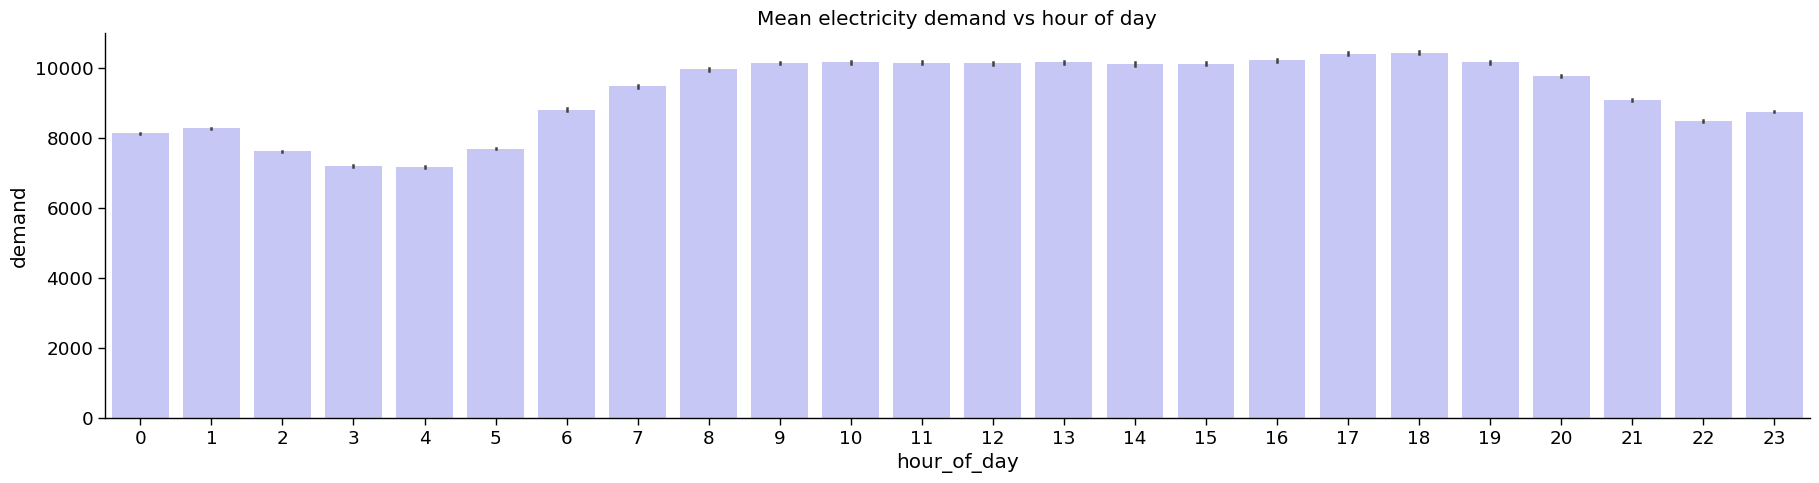

In [9]:
fig, ax = plt.subplots()
sns.barplot(data=result, y="demand", x="hour_of_day", ax=ax, color='b', alpha=0.25)
ax.set_title("Mean electricity demand vs hour of day")

plt.show()

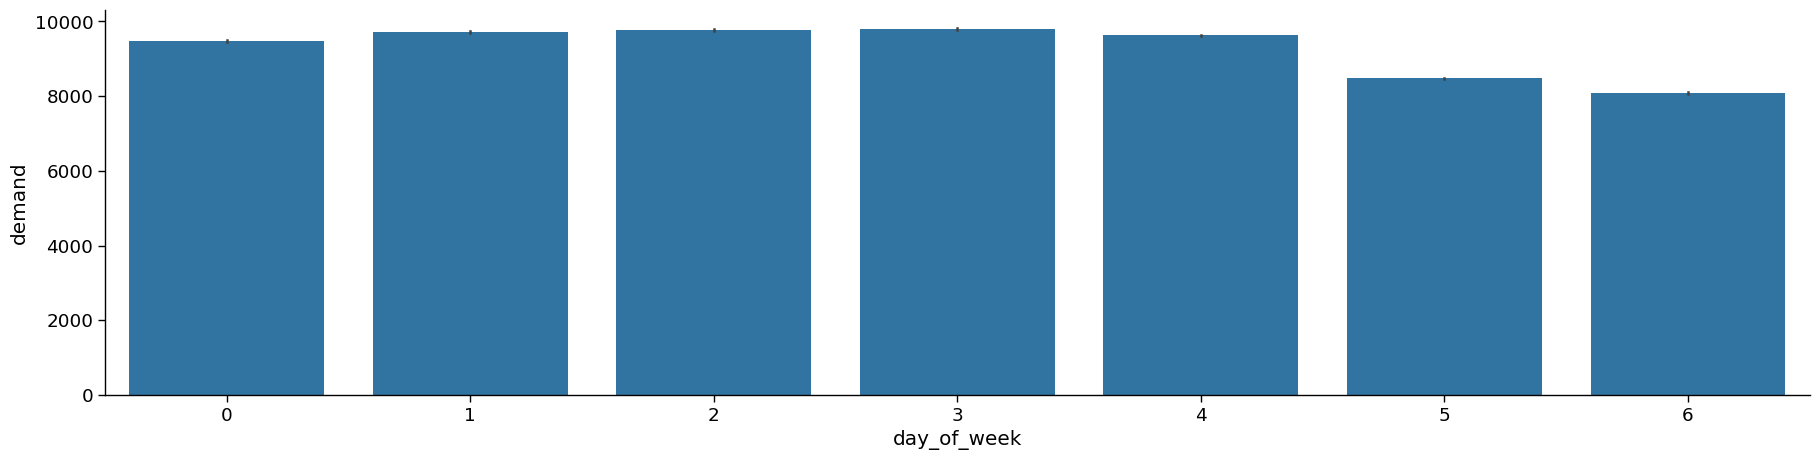

In [10]:
fig, ax = plt.subplots()

sns.barplot(
    data=result,
    y="demand",
    x="day_of_week",
    ax=ax
)

plt.show()

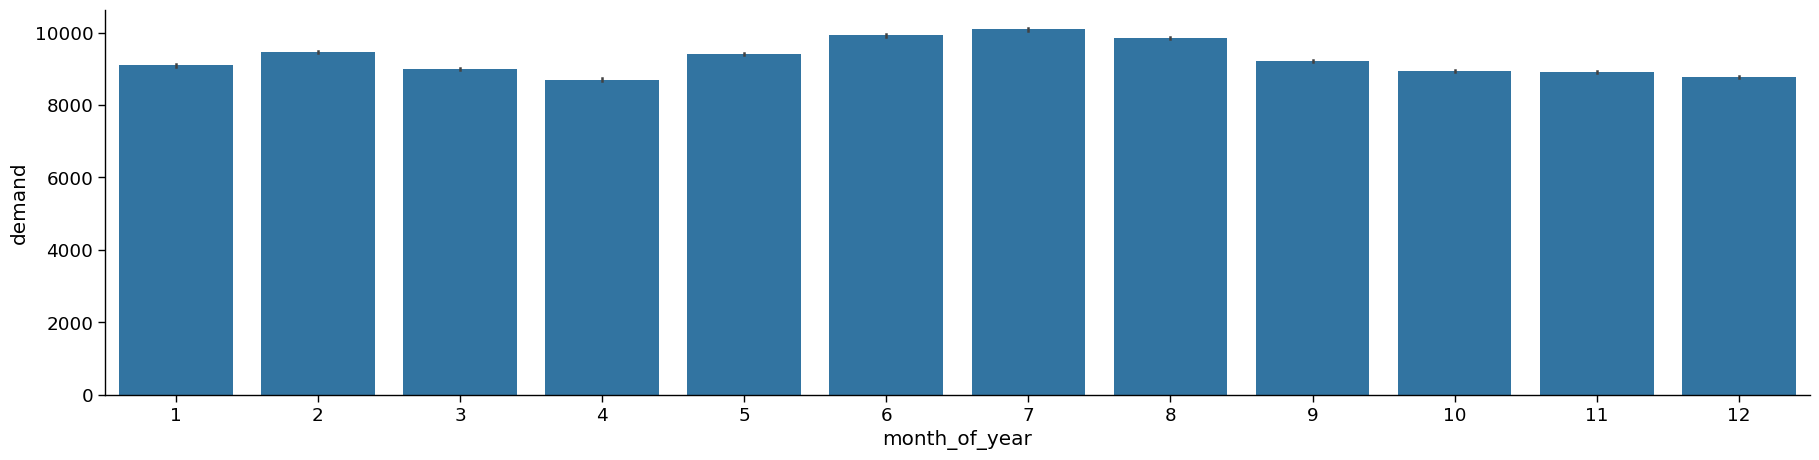

In [11]:
fig, ax = plt.subplots()

sns.barplot(data=result, y="demand", x="month_of_year", ax=ax)

plt.show()

In [12]:
target=["demand"]

df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"


## 3) Feature Engineering

In [13]:
# Polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(),
    PolynomialFeatures(degree=1, include_bias=False)
)

# Datetime features
datetime_features = [
    "month_of_year",
    "week_of_year",
    "day_of_year",
    "day_of_week",
    "hour_of_day",
]

datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features,
    keep_original_columns=False,
)



# Compute lag and window features
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 4],
        "mean": [[1, 24], [1, 24*7]],
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

# Create pipeline
pipeline = make_union(
    datetime_feats,
    time_feats,
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('datetimefeatures',
                                                 DateTimeFeatures(manual_selection=['month_of_year', 'week_of_year',
                                   'day_of_year', 'day_of_week',
                                   'hour_of_day'])),
                                                ('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4], 'mean': [[1, 24], [1, 168]]},
                 target_cols=['demand'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [14]:
pipeline.fit_transform(df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,month_of_year,week_of_year,day_of_year,day_of_week,hour_of_day,time_since_2002-01-01 00:00:00,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_mean_1_24,demand_mean_1_168
date_time,,,,,,,,,,,,
2002-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8174,0.6753,0.0000,0.0000,NaN,NaN
2002-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.8174,0.6753,0.0000,0.0000,NaN,NaN
2002-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,1.0000,0.6753,0.0000,0.0000,NaN,NaN
2002-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.7500,0.7500,0.4376,1.0000,0.0000,0.0000,NaN,NaN
2002-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,NaN,NaN


In [15]:
pipeline = clone(pipeline)

### 4) Recursive Forecast

In [16]:
NUM_WEEKS = 2

# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.
forecast_start_time = df.index.max() - pd.DateOffset(weeks=NUM_WEEKS) # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24*7*NUM_WEEKS

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time,
    periods=num_of_forecast_steps,
    freq="H"
)

# We need the latest 24*7 time periods in our predict dataframe to build our  window features.
look_back_window_size = pd.DateOffset(weeks=1)

### 4.1) Train/Test split

In [17]:
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

In [18]:
model = LGBMRegressor(
    boosting = "gbdt",
    learning_rate=0.1,
    n_estimators=100,
    n_jobs=-1, # Use all cores
)

# Rename column names if is lightGBM
if "lightgbm" in model.__module__:
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))

# Train one-step ahead forecast model
model.fit(X_train, y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 115031, number of used features: 12
[LightGBM] [Info] Start training from score 9276.580886


LGBMRegressor(boosting='gbdt', n_jobs=-1)

In [19]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
    df_predict,
    pd.DataFrame(index=forecast_horizon)
])

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in tqdm(forecast_horizon):
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]
    # Predict one step ahead.
    y_pred = model.predict(X_test)
    # Append forecast to the target variable columnn in our dynamic forecast dataframe `df_predict`.
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

  0%|          | 1/336 [00:00<01:16,  4.38it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  1%|          | 2/336 [00:00<01:15,  4.44it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  1%|          | 3/336 [00:00<01:19,  4.21it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  1%|          | 4/336 [00:00<01:17,  4.26it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  1%|▏         | 5/336 [00:01<01:16,  4.34it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  2%|▏         | 6/336 [00:01<01:20,  4.10it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  2%|▏         | 7/336 [00:01<01:17,  4.22it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  2%|▏         | 8/336 [00:01<01:19,  4.15it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  3%|▎         | 9/336 [00:02<01:25,  3.85it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  3%|▎         | 10/336 [00:02<01:30,  3.60it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  3%|▎         | 11/336 [00:02<01:26,  3.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  4%|▎         | 12/336 [00:03<01:26,  3.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  4%|▍         | 13/336 [00:03<01:33,  3.46it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  4%|▍         | 14/336 [00:03<01:32,  3.49it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  4%|▍         | 15/336 [00:04<02:01,  2.64it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  5%|▍         | 16/336 [00:04<01:58,  2.69it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  5%|▌         | 17/336 [00:04<01:52,  2.84it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  5%|▌         | 18/336 [00:05<01:51,  2.85it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  6%|▌         | 19/336 [00:05<01:40,  3.16it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  6%|▌         | 20/336 [00:05<01:30,  3.49it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  6%|▋         | 21/336 [00:05<01:24,  3.75it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  7%|▋         | 23/336 [00:06<01:18,  4.00it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  7%|▋         | 24/336 [00:06<01:15,  4.12it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  8%|▊         | 26/336 [00:07<01:08,  4.53it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  8%|▊         | 28/336 [00:07<00:55,  5.51it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


  9%|▉         | 30/336 [00:07<00:51,  6.00it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 10%|▉         | 32/336 [00:07<00:48,  6.26it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 10%|█         | 34/336 [00:08<00:46,  6.55it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 11%|█         | 36/336 [00:08<00:44,  6.78it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 11%|█▏        | 38/336 [00:08<00:41,  7.15it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 12%|█▏        | 40/336 [00:09<00:41,  7.09it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 12%|█▎        | 42/336 [00:09<00:41,  7.07it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 13%|█▎        | 44/336 [00:09<00:41,  7.11it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 13%|█▎        | 45/336 [00:09<00:41,  6.93it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 14%|█▍        | 48/336 [00:10<00:44,  6.45it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 15%|█▍        | 50/336 [00:10<00:42,  6.69it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 15%|█▌        | 52/336 [00:10<00:41,  6.77it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 16%|█▌        | 54/336 [00:11<00:40,  7.03it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 17%|█▋        | 56/336 [00:11<00:40,  6.86it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 17%|█▋        | 58/336 [00:11<00:39,  7.02it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 18%|█▊        | 60/336 [00:12<00:39,  6.97it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 18%|█▊        | 62/336 [00:12<00:39,  6.86it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 19%|█▉        | 64/336 [00:12<00:39,  6.88it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 20%|█▉        | 66/336 [00:12<00:41,  6.54it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 20%|██        | 68/336 [00:13<00:39,  6.87it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 21%|██        | 70/336 [00:13<00:38,  6.86it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 21%|██▏       | 72/336 [00:13<00:38,  6.91it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 22%|██▏       | 74/336 [00:14<00:38,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 23%|██▎       | 76/336 [00:14<00:36,  7.07it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 23%|██▎       | 78/336 [00:14<00:37,  6.90it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 24%|██▍       | 80/336 [00:14<00:36,  6.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 24%|██▍       | 82/336 [00:15<00:37,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 25%|██▌       | 84/336 [00:15<00:36,  6.84it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 26%|██▌       | 86/336 [00:15<00:35,  7.02it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 26%|██▌       | 88/336 [00:16<00:35,  6.94it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 27%|██▋       | 90/336 [00:16<00:35,  6.86it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 27%|██▋       | 92/336 [00:16<00:35,  6.89it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 28%|██▊       | 94/336 [00:16<00:36,  6.60it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 28%|██▊       | 95/336 [00:17<00:41,  5.80it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 29%|██▊       | 96/336 [00:17<00:44,  5.36it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 29%|██▉       | 97/336 [00:17<00:49,  4.85it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 29%|██▉       | 98/336 [00:17<00:49,  4.77it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 29%|██▉       | 99/336 [00:18<00:50,  4.68it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 30%|██▉       | 100/336 [00:18<00:51,  4.56it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 30%|███       | 101/336 [00:18<00:52,  4.47it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 30%|███       | 102/336 [00:18<00:52,  4.48it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 31%|███       | 104/336 [00:19<00:50,  4.59it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 31%|███▏      | 105/336 [00:19<00:51,  4.50it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 32%|███▏      | 106/336 [00:19<00:52,  4.41it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 32%|███▏      | 108/336 [00:20<00:44,  5.10it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 33%|███▎      | 110/336 [00:20<00:39,  5.76it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 33%|███▎      | 112/336 [00:20<00:35,  6.38it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 34%|███▍      | 114/336 [00:20<00:32,  6.81it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 35%|███▍      | 116/336 [00:21<00:31,  6.90it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 35%|███▌      | 118/336 [00:21<00:31,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 36%|███▌      | 120/336 [00:21<00:30,  6.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 36%|███▋      | 122/336 [00:22<00:31,  6.89it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 37%|███▋      | 124/336 [00:22<00:32,  6.61it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 38%|███▊      | 126/336 [00:22<00:30,  6.81it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 38%|███▊      | 128/336 [00:22<00:30,  6.86it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 39%|███▊      | 130/336 [00:23<00:30,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 39%|███▉      | 132/336 [00:23<00:30,  6.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 40%|███▉      | 134/336 [00:23<00:29,  6.94it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 40%|████      | 136/336 [00:24<00:28,  7.12it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 41%|████      | 138/336 [00:24<00:29,  6.80it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 42%|████▏     | 140/336 [00:24<00:27,  7.08it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 42%|████▏     | 142/336 [00:24<00:27,  7.09it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 43%|████▎     | 144/336 [00:25<00:27,  7.11it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 43%|████▎     | 146/336 [00:25<00:27,  7.01it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 44%|████▍     | 148/336 [00:25<00:26,  7.06it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 45%|████▍     | 150/336 [00:26<00:26,  7.07it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 45%|████▌     | 152/336 [00:26<00:26,  6.84it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 46%|████▌     | 154/336 [00:26<00:26,  6.95it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 46%|████▋     | 156/336 [00:26<00:25,  7.16it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 47%|████▋     | 158/336 [00:27<00:24,  7.14it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 48%|████▊     | 160/336 [00:27<00:25,  6.89it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 48%|████▊     | 162/336 [00:27<00:24,  7.04it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 49%|████▉     | 164/336 [00:28<00:24,  7.13it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 49%|████▉     | 166/336 [00:28<00:24,  7.05it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 50%|█████     | 168/336 [00:28<00:24,  6.85it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 51%|█████     | 170/336 [00:28<00:23,  6.98it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 51%|█████     | 172/336 [00:29<00:23,  7.09it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 52%|█████▏    | 174/336 [00:29<00:23,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 52%|█████▏    | 176/336 [00:29<00:23,  6.75it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 53%|█████▎    | 177/336 [00:30<00:25,  6.14it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 53%|█████▎    | 178/336 [00:30<00:27,  5.68it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 53%|█████▎    | 179/336 [00:30<00:29,  5.37it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 54%|█████▎    | 180/336 [00:30<00:30,  5.06it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 54%|█████▍    | 181/336 [00:30<00:31,  4.92it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 54%|█████▍    | 182/336 [00:31<00:31,  4.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 54%|█████▍    | 183/336 [00:31<00:32,  4.76it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 55%|█████▍    | 184/336 [00:31<00:32,  4.67it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 55%|█████▌    | 185/336 [00:31<00:33,  4.52it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 55%|█████▌    | 186/336 [00:32<00:32,  4.60it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 56%|█████▌    | 187/336 [00:32<00:31,  4.66it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 56%|█████▌    | 188/336 [00:32<00:31,  4.65it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 57%|█████▋    | 190/336 [00:32<00:30,  4.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 57%|█████▋    | 192/336 [00:33<00:25,  5.64it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 58%|█████▊    | 194/336 [00:33<00:22,  6.19it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 58%|█████▊    | 196/336 [00:33<00:21,  6.47it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 59%|█████▉    | 198/336 [00:34<00:20,  6.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 60%|█████▉    | 200/336 [00:34<00:19,  6.87it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 60%|██████    | 202/336 [00:34<00:19,  6.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 61%|██████    | 204/336 [00:34<00:19,  6.88it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 61%|██████▏   | 206/336 [00:35<00:18,  7.02it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 62%|██████▏   | 208/336 [00:35<00:18,  6.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 62%|██████▎   | 210/336 [00:35<00:18,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 63%|██████▎   | 212/336 [00:36<00:17,  6.89it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 64%|██████▎   | 214/336 [00:36<00:17,  7.02it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 64%|██████▍   | 216/336 [00:36<00:17,  6.88it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 65%|██████▍   | 218/336 [00:36<00:17,  6.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 65%|██████▌   | 220/336 [00:37<00:16,  6.95it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 66%|██████▌   | 222/336 [00:37<00:16,  7.10it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 67%|██████▋   | 224/336 [00:37<00:16,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 67%|██████▋   | 226/336 [00:38<00:16,  6.71it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 68%|██████▊   | 228/336 [00:38<00:15,  6.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 68%|██████▊   | 230/336 [00:38<00:15,  6.93it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 69%|██████▉   | 232/336 [00:38<00:15,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 70%|██████▉   | 234/336 [00:39<00:14,  6.93it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 70%|███████   | 236/336 [00:39<00:14,  7.07it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 71%|███████   | 238/336 [00:39<00:14,  6.98it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 71%|███████▏  | 240/336 [00:40<00:13,  7.00it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 72%|███████▏  | 242/336 [00:40<00:13,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 73%|███████▎  | 244/336 [00:40<00:13,  6.81it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 73%|███████▎  | 246/336 [00:41<00:13,  6.60it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 74%|███████▍  | 248/336 [00:41<00:13,  6.63it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 74%|███████▍  | 250/336 [00:41<00:12,  6.87it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 75%|███████▌  | 252/336 [00:41<00:12,  6.93it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 76%|███████▌  | 254/336 [00:42<00:12,  6.81it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 76%|███████▌  | 256/336 [00:42<00:12,  6.67it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 77%|███████▋  | 258/336 [00:42<00:11,  6.74it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 77%|███████▋  | 259/336 [00:43<00:12,  5.98it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 77%|███████▋  | 260/336 [00:43<00:14,  5.31it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 78%|███████▊  | 261/336 [00:43<00:15,  4.99it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 78%|███████▊  | 262/336 [00:43<00:15,  4.91it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 78%|███████▊  | 263/336 [00:43<00:15,  4.84it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 79%|███████▊  | 264/336 [00:44<00:15,  4.69it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 79%|███████▉  | 265/336 [00:44<00:15,  4.72it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 79%|███████▉  | 266/336 [00:44<00:15,  4.52it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 79%|███████▉  | 267/336 [00:44<00:15,  4.43it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 80%|███████▉  | 268/336 [00:45<00:14,  4.53it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 80%|████████  | 269/336 [00:45<00:15,  4.43it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 80%|████████  | 270/336 [00:45<00:15,  4.38it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 81%|████████  | 272/336 [00:45<00:13,  4.79it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 82%|████████▏ | 274/336 [00:46<00:10,  5.72it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 82%|████████▏ | 276/336 [00:46<00:09,  6.22it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 83%|████████▎ | 278/336 [00:46<00:08,  6.50it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 83%|████████▎ | 280/336 [00:47<00:08,  6.82it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 84%|████████▍ | 282/336 [00:47<00:07,  6.91it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 85%|████████▍ | 284/336 [00:47<00:07,  6.69it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 85%|████████▌ | 286/336 [00:47<00:07,  6.61it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 86%|████████▌ | 288/336 [00:48<00:07,  6.76it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 86%|████████▋ | 290/336 [00:48<00:06,  6.71it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 87%|████████▋ | 292/336 [00:48<00:06,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 88%|████████▊ | 294/336 [00:49<00:05,  7.04it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 88%|████████▊ | 296/336 [00:49<00:05,  6.83it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 89%|████████▊ | 298/336 [00:49<00:05,  7.00it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 89%|████████▉ | 300/336 [00:49<00:05,  7.09it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 90%|████████▉ | 302/336 [00:50<00:04,  6.94it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 90%|█████████ | 304/336 [00:50<00:04,  6.89it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 91%|█████████ | 306/336 [00:50<00:04,  6.64it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 92%|█████████▏| 308/336 [00:51<00:04,  6.78it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 92%|█████████▏| 310/336 [00:51<00:03,  6.68it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 93%|█████████▎| 312/336 [00:51<00:03,  6.81it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 93%|█████████▎| 314/336 [00:52<00:03,  6.76it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 94%|█████████▍| 316/336 [00:52<00:02,  6.70it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 95%|█████████▍| 318/336 [00:52<00:02,  6.50it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 95%|█████████▌| 320/336 [00:52<00:02,  6.71it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 96%|█████████▌| 322/336 [00:53<00:02,  6.95it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 96%|█████████▋| 324/336 [00:53<00:01,  6.66it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 97%|█████████▋| 326/336 [00:53<00:01,  6.63it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 98%|█████████▊| 328/336 [00:54<00:01,  6.71it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 98%|█████████▊| 330/336 [00:54<00:00,  6.88it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 99%|█████████▉| 332/336 [00:54<00:00,  6.64it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 99%|█████████▉| 334/336 [00:55<00:00,  6.90it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


100%|██████████| 336/336 [00:55<00:00,  6.07it/s]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [20]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


### 4.2) Plot results

In [21]:
# Error metrics:
comp_forecast_real = pd.merge(
    left=y_forecast,
    right=y_test,
    left_index=True,
    right_index=True).rename(columns={"demand_x": "forecast", "demand_y": "real"})

mape = c_mape(y=comp_forecast_real["real"], y_hat=comp_forecast_real["forecast"])
mse = mean_squared_error(
    y_true=y_test.loc[y_forecast.index],
    y_pred=y_forecast,
    squared=False
)

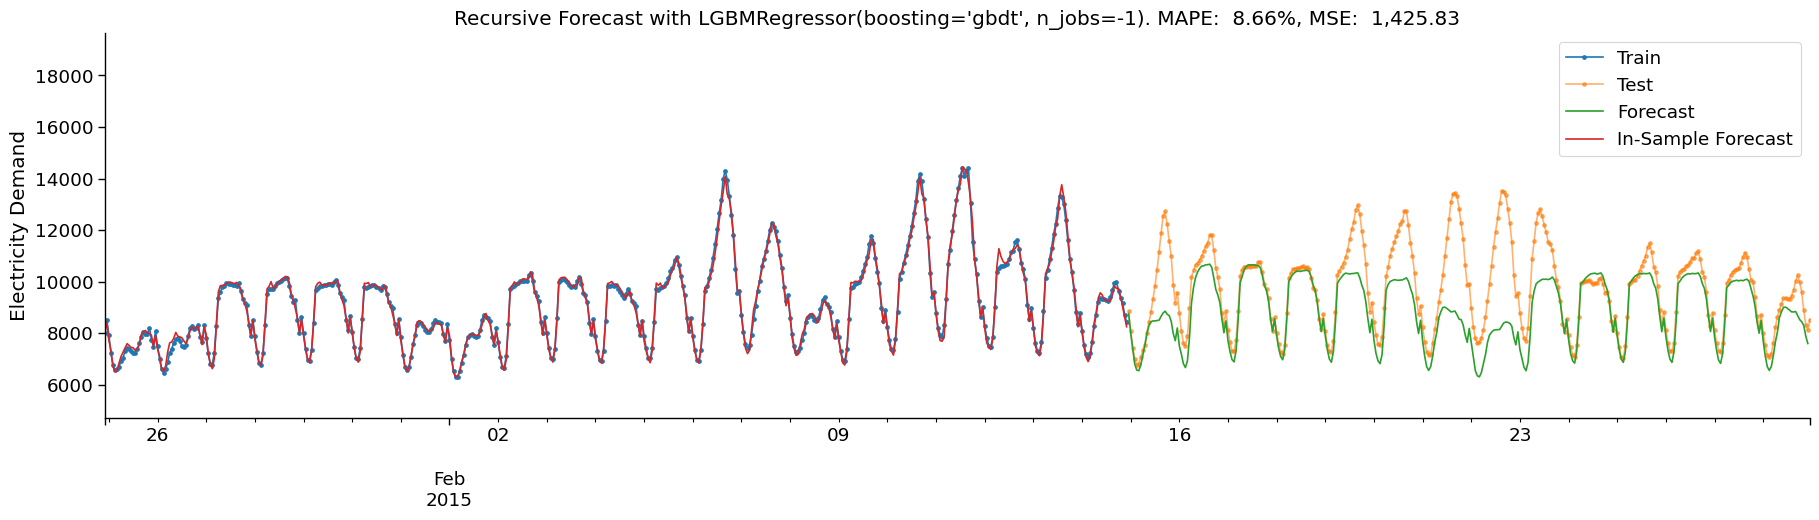

In [22]:
WEEK_PLOT = 3

fig, ax = plt.subplots()

# Plot training set.
y_train.plot(ax=ax, marker='.')
y_test.plot(ax=ax, marker='.', alpha=0.6)

y_forecast.plot(ax=ax)
y_forecast_train.plot(ax=ax)

ax.set_title(f"Recursive Forecast with {model}. MAPE: {mape: .2%}, MSE: {mse: ,.2f}")
ax.legend(["Train", "Test", "Forecast", "In-Sample Forecast"])

ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=WEEK_PLOT))
ax.set_xlabel("")
ax.set_ylabel("Electricity Demand")

plt.show()

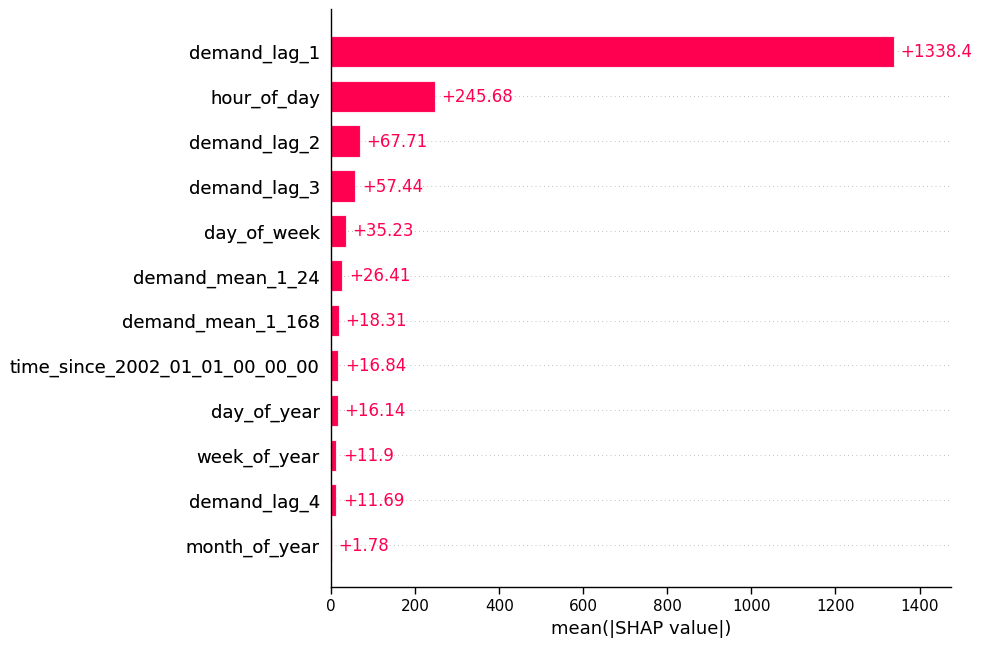

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

# Shap plot
shap.plots.bar(shap_values, max_display=len(X_train.columns))